In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.colors

import dateutil.parser

In [2]:
def time_converter(data, minute=False):
    x = data.split('-')
    if len(x)==1:
        d = 0
        x = x[0]
    else:
        d = int(x[0])
        x = x[1]
    h,m,s = map(int,x.split(':'))
    if minute == True:
        return (d*24 + h)*60 + m + s/60
    return (((d*24 + h)*60+m)*60+s)/60

In [3]:
def memory_size_converter(size):
    giga = True
    if 'M' in size:
        giga = False
    num = float(size.rstrip('MnGc'))
    if giga:
        return num*1024
    return num

In [4]:
df = pd.read_csv('accre_slurm_request_info.csv', delimiter="|")

In [5]:
# get requested time in minutes
df['Timelimit_num'] = df['ReqTime'].astype(str)
df['Timelimit_num'] = df.Timelimit_num.apply(time_converter)

In [6]:
def datetime_to_minutes(d):
    return d.seconds/60

df['Start_dt'] = df.Start.apply(dateutil.parser.parse)
df['Submit_dt'] = df.Submission.apply(dateutil.parser.parse)
df["WaitTime(min)"] = df['Start_dt'] - df['Submit_dt']
df['WaitTime(min)'] = df["WaitTime(min)"].apply(datetime_to_minutes)

In [7]:
df['ReqMem_num'] = df.ReqMem.apply(memory_size_converter)

In [35]:
# volume in node hours
df['Volume'] = df['Timelimit_num'] * df['NNodes'] / 60 

In [8]:
df.head()

,Submission,Start,Stop,State,NNodes,NCpus,ReqMem,ReqTime,NodeList,Timelimit_num,Start_dt,Submit_dt,WaitTime(min),ReqMem_num
0,2017-12-24T12:04:39,2017-12-25T14:23:37,2017-12-26T17:27:47,COMPLETED,2,1,40000Mn,4-00:00:00,vmp222,5760.0,2017-12-25 14:23:37,2017-12-24 12:04:39,138.966667,40000.0
1,2017-12-24T13:04:36,2017-12-25T14:29:44,2017-12-26T02:44:26,COMPLETED,2,1,40000Mn,4-00:00:00,vmp1308,5760.0,2017-12-25 14:29:44,2017-12-24 13:04:36,85.133333,40000.0
2,2017-12-24T13:04:37,2017-12-25T14:56:44,2017-12-26T17:46:46,COMPLETED,2,1,40000Mn,4-00:00:00,vmp238,5760.0,2017-12-25 14:56:44,2017-12-24 13:04:37,112.116667,40000.0
3,2017-12-24T13:04:39,2017-12-25T15:05:35,2017-12-26T02:49:42,COMPLETED,2,1,40000Mn,4-00:00:00,vmp1368,5760.0,2017-12-25 15:05:35,2017-12-24 13:04:39,120.933333,40000.0
4,2017-12-24T13:04:39,2017-12-25T15:07:56,2017-12-26T01:22:02,COMPLETED,2,1,40000Mn,4-00:00:00,vmp1301,5760.0,2017-12-25 15:07:56,2017-12-24 13:04:39,123.283333,40000.0


# Create parameter bins

In [9]:
# only keep entries that ran over 10 minutes
df = df[df.Timelimit_num > 10]
# only keep entries that request over 1 GB
df = df[df.ReqMem_num > 1024]
len(df)

2899807

In [10]:
accre_node_mem = np.array([1, 48, 64, 96, 128, 256]) * 1024
accre_node_mem

array([  1024,  49152,  65536,  98304, 131072, 262144])

In [11]:
print("Min Reg Memory %.2f" %(df["ReqMem_num"].min()))
print("Max Reg Memory %.2f" %(df["ReqMem_num"].max()))

Min Reg Memory 1052.00
Max Reg Memory 503808.00


In [12]:
memory_bins = [1024, 49152,  65536,  98304, 131072, 262144]

In [13]:
print("Min Walltime %.2f" %(df["Timelimit_num"].min()))
print("Max Walltime %.2f" %(df["Timelimit_num"].max()))

Min Walltime 12.00
Max Walltime 20160.00


In [14]:
walltime_bins = [10, 120, 600, 1440, 10080, 21000]

In [15]:
print("Min NNodes %.2f" %(df["NNodes"].min()))
print("Max NNodes %.2f" %(df["NNodes"].max()))

Min NNodes 1.00
Max NNodes 350.00


In [16]:
nodes_bins = [1, 2, 5, 10, 100, 350]

In [38]:
#df.groupby(['NNodes']).agg(['mean', 'std'])
df.groupby(pd.cut(df["WaitTime(min)"], [0, 1, 10, 60, 600, 1200, 1500])).mean()

,NNodes,NCpus,Timelimit_num,WaitTime(min),ReqMem_num,Volume
WaitTime(min),,,,,,
"(0, 1]",1.544224,1.505961,1244.997683,0.224887,8772.490715,31.036033
"(1, 10]",1.646960,1.606366,1156.628562,4.293983,10573.113049,35.667283
"(10, 60]",1.655247,1.623650,1564.767381,33.309729,11530.486488,49.114804
"(60, 600]",1.414303,1.378265,817.546578,274.686149,12447.502636,28.438272
"(600, 1200]",1.526075,1.426194,727.145119,848.800624,14651.759566,27.076532
"(1200, 1500]",1.599993,1.593711,730.991694,1320.201481,13804.507575,25.551873


# Plot wait time to requested memory

### Create bins of memory / time requests

In [22]:
df_mean = df.groupby(['NNodes', 'ReqMem_num']).mean().reset_index()
df_mean

,NNodes,ReqMem_num,NCpus,Timelimit_num,WaitTime(min)
0,1,1052.0,1.0,4022.000000,118.921667
1,1,1116.0,1.0,4023.000000,128.319444
2,1,1189.0,1.0,4023.000000,79.919444
3,1,1500.0,1.0,690.000000,0.008333
4,1,1586.0,1.0,4024.000000,26.048333
...,...,...,...,...,...
545,288,5120.0,288.0,1550.769231,34.501282
546,288,8192.0,288.0,3600.000000,9.100000
547,288,10240.0,288.0,4320.000000,35.933333
548,300,20480.0,300.0,3720.000000,131.166667


In [30]:
print(len(df_mean), df_mean["WaitTime(min)"].max())
df_mean[df_mean["WaitTime(min)"]<600].count()

550 1144.6833333333334


NNodes           536
ReqMem_num       536
NCpus            536
Timelimit_num    536
WaitTime(min)    536
dtype: int64

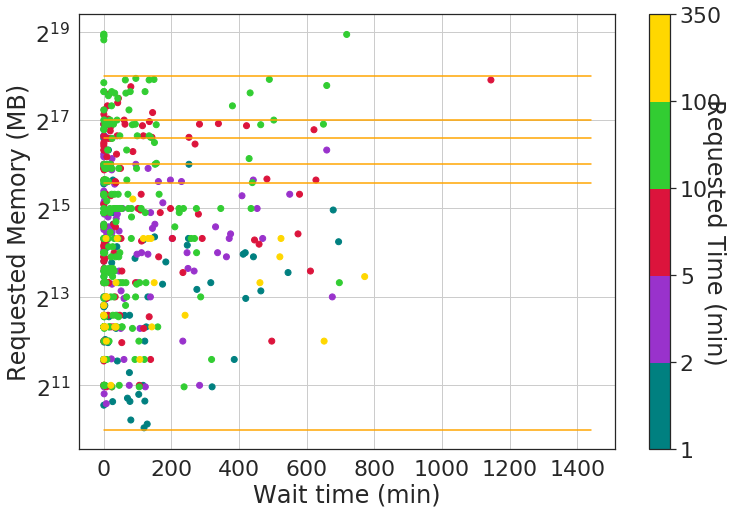

In [34]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")

bounds = nodes_bins
colors = ["teal", "darkorchid", "crimson", "limegreen", "gold"]
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, len(colors))

sc = ax.scatter(df_mean["WaitTime(min)"], df_mean.ReqMem_num,
                c=df_mean.NNodes.values, cmap=cmap, norm=norm)

# set the ACCRE resources
for i in accre_node_mem:
    plt.plot([0, df["WaitTime(min)"].max()], [i, i], color='orange')

cbar = fig.colorbar(sc, spacing="uniform")
cbar.ax.set_ylabel('Requested Time (min)', rotation=270)

plt.grid(True)
ax.set_xlabel('Wait time (min)')
ax.set_ylabel('Requested Memory (MB)')

ax.set_yscale('log', basey=2)
#plt.savefig("figures/wait_time_memory_all.png")
plt.show()

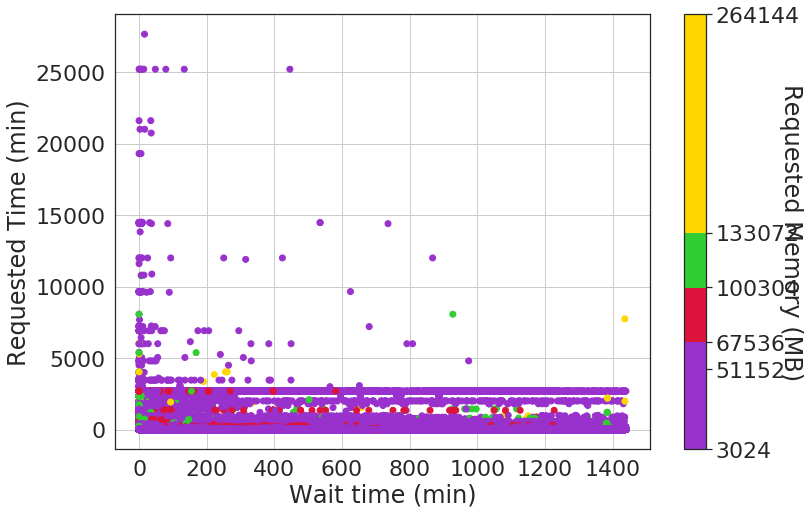

In [36]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")

bounds = [2000] + accre_node_mem
#bounds = [2000, 10000, 20000, 50000, 100000]
colors = ["darkorchid", "crimson", "limegreen", "gold"]
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, len(colors))

sc = ax.scatter(df["WaitTime(min)"], df.Volume,
                c=df.ReqMem_num.values, cmap=cmap, norm=norm)

cbar = fig.colorbar(sc, spacing="proportional")
cbar.ax.set_ylabel('Requested Memory (MB)', rotation=270)

plt.grid(True)
ax.set_xlabel('Wait time (min)')
ax.set_ylabel('Requested Time (min)')

#plt.savefig("figures/wait_time_walltime_all.png")
plt.show()